1. Project Overview
Business Understanding

Depression remains a major public health challenge, and early detection is critical. The goal of this project is to:
- Explore synthetic depression related survey data
- Identify patterns in demographic and behavioral variables
- Build baseline classification models to predict depression likelihood
- Compare model performance using consistent metrics
- Provide actionable recommendations informed by the findings

2. Import Libraries

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid", context="notebook")

3. Load Dataset

In [14]:
#Dataset is created in the original CSV file
#This file will be only extracting the final data
df = pd.read_csv("/Users/michaeltucker/Capstone Project/data/depression_synth_clean_for_modeling.csv")
df.head()

,age,gender,education,employment,sleep_duration_hrs,sleep_quality,physical_activity_min_per_week,screen_time_hrs_daily,social_media_hrs_daily,nutrition_score,num_meaningful_relationships,time_with_others_hrs_daily,phq9_score,depression_label
0,56,female,bachelors,unemployed,5.78,0.471,10.7,1.79,0.88,0.571,1,1.17,22,1
1,69,male,high_school,retired,7.55,0.903,33.0,1.79,2.31,0.080,2,2.17,14,1
2,46,male,bachelors,employed,5.89,0.720,31.1,3.03,0.05,0.447,5,2.56,11,1
3,32,female,phd,employed,8.30,0.683,25.9,0.70,1.32,0.706,4,1.46,8,0
4,60,male,bachelors,employed,7.23,0.452,3.6,2.60,1.35,0.507,5,2.02,13,1


4. Initial Dataset Overview

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             2000 non-null   int64  
 1   gender                          2000 non-null   object 
 2   education                       2000 non-null   object 
 3   employment                      2000 non-null   object 
 4   sleep_duration_hrs              2000 non-null   float64
 5   sleep_quality                   2000 non-null   float64
 6   physical_activity_min_per_week  2000 non-null   float64
 7   screen_time_hrs_daily           2000 non-null   float64
 8   social_media_hrs_daily          2000 non-null   float64
 9   nutrition_score                 2000 non-null   float64
 10  num_meaningful_relationships    2000 non-null   int64  
 11  time_with_others_hrs_daily      2000 non-null   float64
 12  phq9_score                      20

In [16]:
df.describe()

,age,sleep_duration_hrs,sleep_quality,physical_activity_min_per_week,screen_time_hrs_daily,social_media_hrs_daily,nutrition_score,num_meaningful_relationships,time_with_others_hrs_daily,phq9_score,depression_label
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,46.362500,6.947180,0.717796,31.437933,3.10253,1.508584,0.576360,2.976500,1.508365,13.684500,0.834500
std,16.419924,1.549815,0.151732,31.557559,1.57305,1.491512,0.169354,1.721752,1.104279,4.394954,0.371724
min,18.000000,3.000000,0.138000,0.000000,0.00000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,5.867500,0.630000,9.800000,2.05000,0.460000,0.454750,2.000000,0.590000,11.000000,1.000000
50%,46.500000,6.930000,0.735500,22.150000,3.08000,1.090000,0.577000,3.000000,1.440000,14.000000,1.000000
75%,61.000000,8.030000,0.833000,41.700000,4.09000,1.950000,0.702000,4.000000,2.252500,17.000000,1.000000
max,74.000000,11.000000,0.997000,268.800000,18.76000,11.260000,0.986000,10.000000,5.500000,27.000000,1.000000


5. Exploratory Data Analysis

5.1 Target Variable Distribution

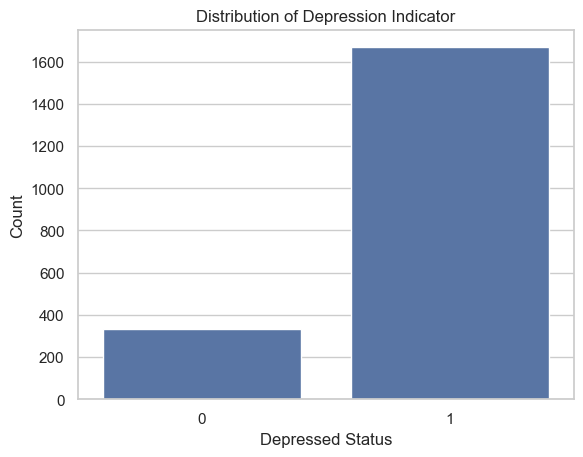

In [18]:
# A simple bar plot to check class balance (0 = not depressed, 1 = depressed)
sns.countplot(data=df, x="depression_label")
plt.title("Distribution of Depression Indicator")
plt.xlabel("Depressed Status")
plt.ylabel("Count")
plt.show()

5.2 Numeric Feature Distributions

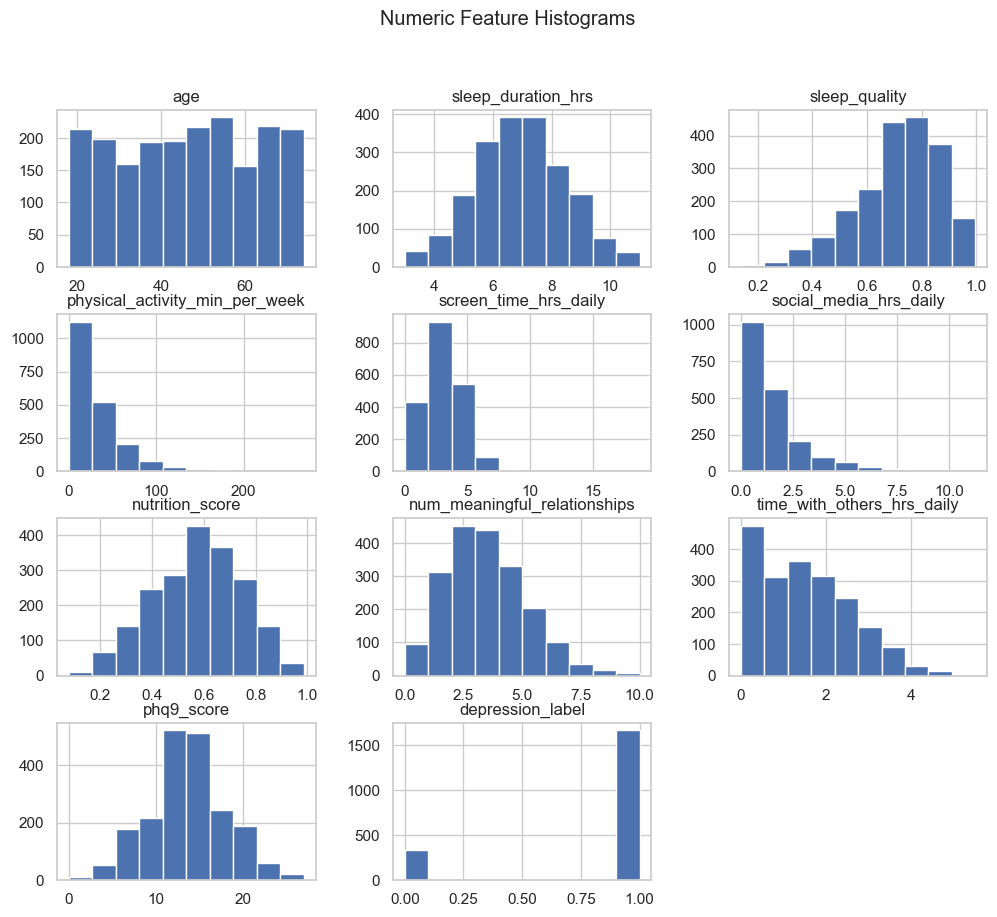

In [20]:
# Identify numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Plot all numeric columns to see their distributions
df[num_cols].hist(figsize=(12,10))
plt.suptitle("Numeric Feature Histograms")
plt.show()

5.3 Correlation Heatmap

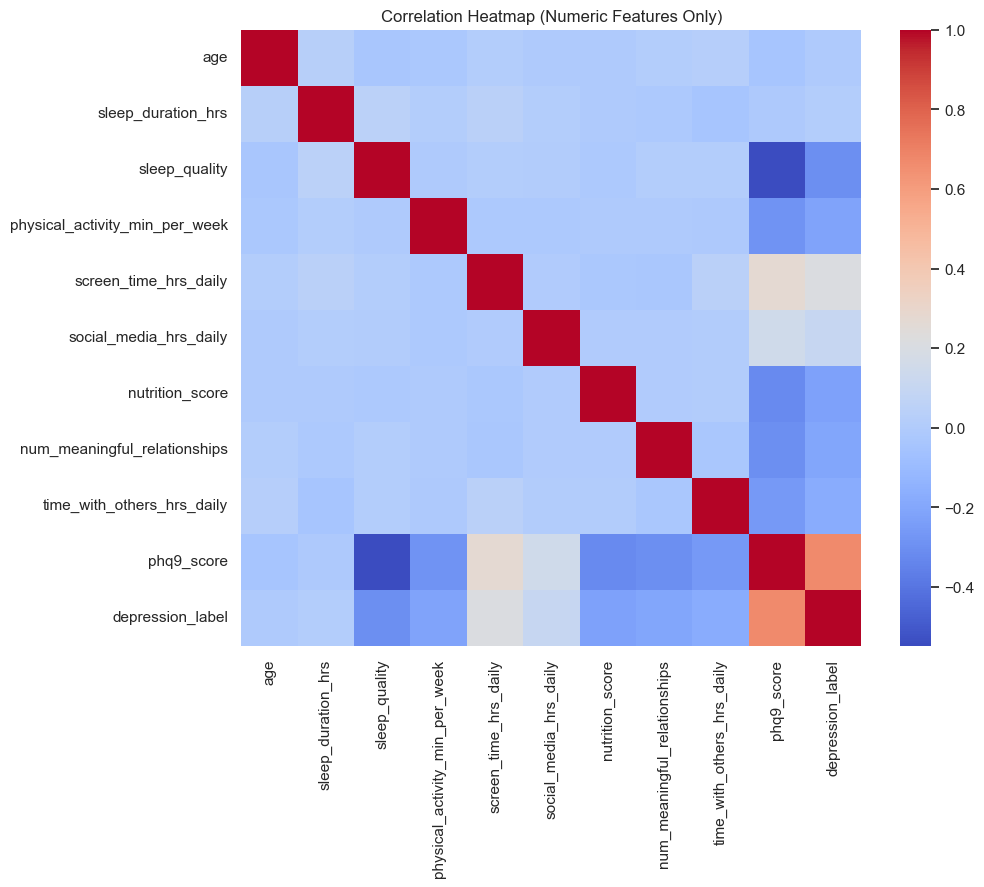

In [22]:
# Select only numeric columns to avoid errors (corr() cannot handle strings)
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Display correlations between numeric variables
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

5.4 Categorical Feature Visualizations

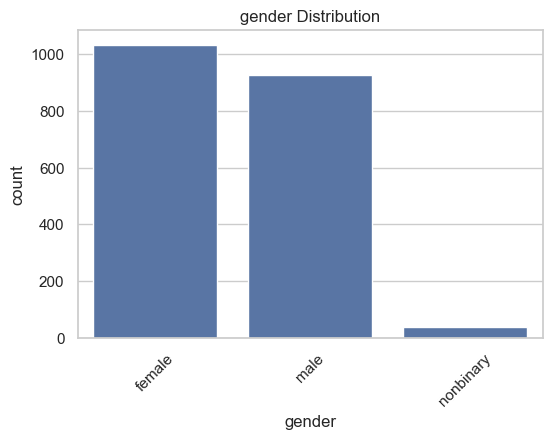

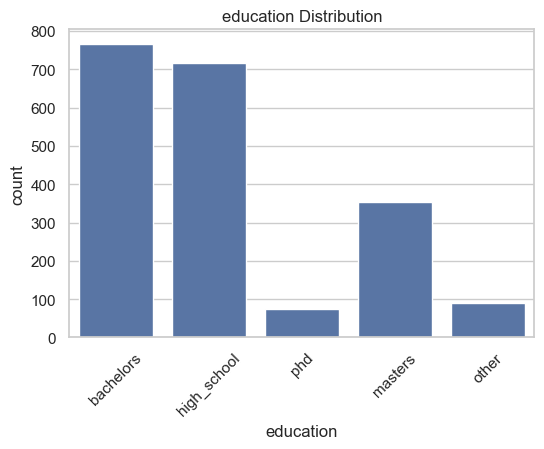

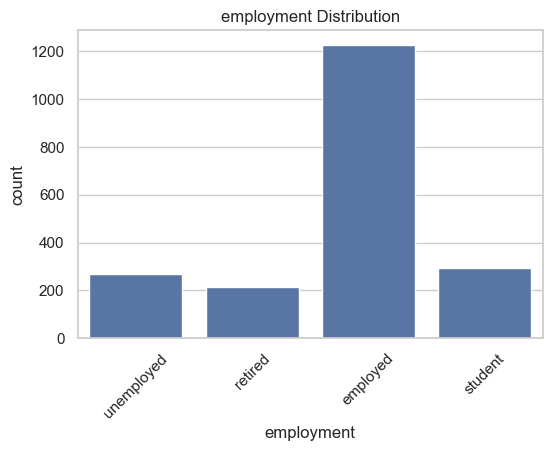

In [23]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# Bar plots for each categorical column
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.show()

6. Preprocess the Data

6.1 Ensure Target Type Is Correct

In [29]:
# Convert target variable to integer in case it was stored as object/string
df['depression_label'] = df['depression_label'].astype(int)

6.2 Encode Categorical Variables

In [30]:
# Convert categorical variables into numerical columns using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# drop_first prevents duplicate/overlapping dummy columns
df_encoded.head()

,age,sleep_duration_hrs,sleep_quality,physical_activity_min_per_week,screen_time_hrs_daily,social_media_hrs_daily,nutrition_score,num_meaningful_relationships,time_with_others_hrs_daily,phq9_score,depression_label,gender_male,gender_nonbinary,education_high_school,education_masters,education_other,education_phd,employment_retired,employment_student,employment_unemployed
0,56,5.78,0.471,10.7,1.79,0.88,0.571,1,1.17,22,1,False,False,False,False,False,False,False,False,True
1,69,7.55,0.903,33.0,1.79,2.31,0.080,2,2.17,14,1,True,False,True,False,False,False,True,False,False
2,46,5.89,0.720,31.1,3.03,0.05,0.447,5,2.56,11,1,True,False,False,False,False,False,False,False,False
3,32,8.30,0.683,25.9,0.70,1.32,0.706,4,1.46,8,0,False,False,False,False,False,True,False,False,False
4,60,7.23,0.452,3.6,2.60,1.35,0.507,5,2.02,13,1,True,False,False,False,False,False,False,False,False


6.3 Train-Test Split

In [32]:
# Define features (X) and target (y)
X = df_encoded.drop("depression_label", axis=1)
y = df_encoded["depression_label"]

# Split into training and testing sets
# stratify=y ensures the class proportions remain balanced in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

7. Baseline Model: Logistic Regression

7.1 Feature Scaling

In [33]:
# Logistic Regression works best when numeric features are scaled
scaler = StandardScaler()

# Fit on training data only to avoid leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

7.2 Train Logistic Regression

In [34]:
# Initialize logistic regression with increased max_iter to ensure convergence
log_reg = LogisticRegression(max_iter=500)

# Train model
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

7.3 Evaluate Model Performance

In [35]:
# Generate predictions
log_pred = log_reg.predict(X_test_scaled)

# Display accuracy and detailed classification metrics
print("Accuracy:", accuracy_score(y_test, log_pred))
print("\nClassification Report:\n", classification_report(y_test, log_pred))

Accuracy: 0.985

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        66
           1       0.98      1.00      0.99       334

    accuracy                           0.98       400
   macro avg       0.99      0.95      0.97       400
weighted avg       0.99      0.98      0.98       400



8. Cross-Validation for Baseline Model

In [36]:
# Use 5-fold cross-validation to evaluate model stability
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5)

print("Cross-Validation Mean Accuracy:", cv_scores.mean())
print("Cross-Validation Std Dev:", cv_scores.std())

Cross-Validation Mean Accuracy: 0.9962500000000001
Cross-Validation Std Dev: 0.0023385358667336992


9. Model 2: Random Forest Classifier

9.1 Train Random Forest

In [37]:
# Random Forest handles nonlinear relationships and mixed data types
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

Random Forest Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00       334

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



10. Grid Search Hyperparameter Tuning

In [38]:
# Define parameter grid to search
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
}

# GridSearchCV tests all combinations using cross-validation
grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,   # use all CPU cores
)

# Fit grid search on training data
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

10.1 Display Best Parameters

In [40]:
grid.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}

10.2 Evaluate Tuned Random Forest

In [42]:
# Retrieve the best-performing model
best_rf = grid.best_estimator_

# Make predictions
best_pred = best_rf.predict(X_test)

print("Tuned Random Forest Accuracy:", accuracy_score(y_test, best_pred))
print("\nClassification Report:\n", classification_report(y_test, best_pred))

Tuned Random Forest Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00       334

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



11. Feature Importance

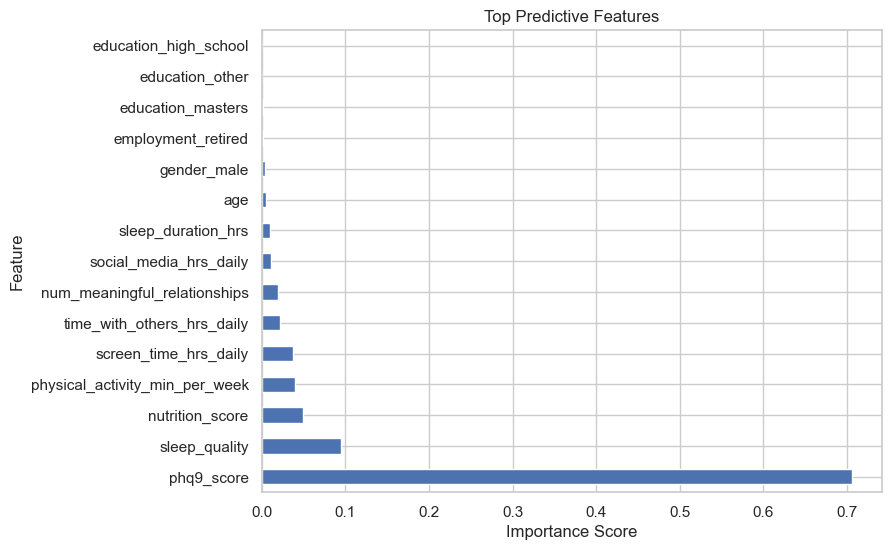

In [43]:
# Extract feature importances from the tuned model
importances = pd.Series(best_rf.feature_importances_, index=X.columns)

# Plot the top 15 most important features
importances.sort_values(ascending=False).head(15).plot(kind='barh', figsize=(8,6))
plt.title("Top Predictive Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

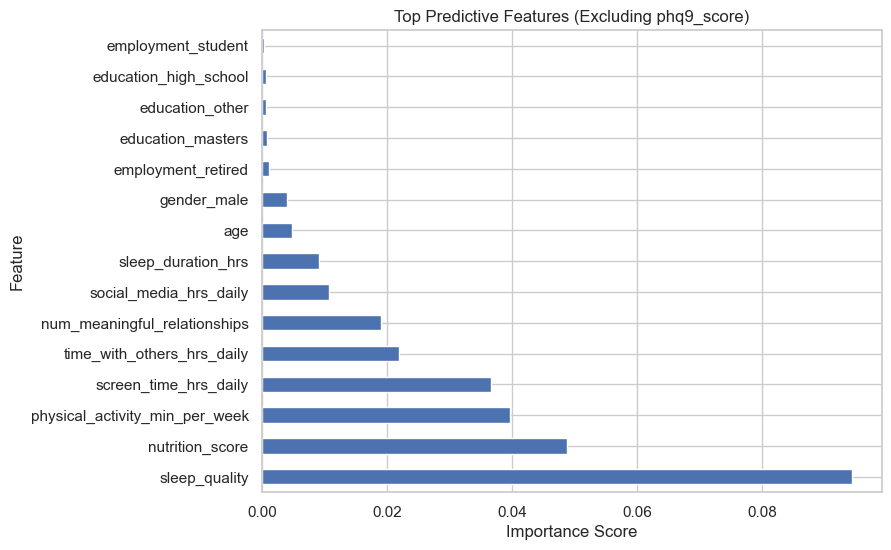

In [45]:
# Remove phq9 score before computing or plotting importances
#phq9 score was skewing the grapn too much
filtered_columns = [col for col in X.columns if col != "phq9_score"]

# Recompute importances using only the filtered list
filtered_importances = pd.Series(best_rf.feature_importances_, index=X.columns)

# Drop phq9_score from the importance series
if "phq9_score" in filtered_importances.index:
    filtered_importances = filtered_importances.drop("phq9_score")

# Plot the top 15 most important features again
filtered_importances.sort_values(ascending=False).head(15).plot(
    kind='barh', figsize=(8,6)
)

plt.title("Top Predictive Features (Excluding phq9_score)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

12. Findings and Interpretation

Major EDA Insights
- The target variable is moderately imbalanced, requiring careful metric selection.
- Several demographic and behavioral variables show strong correlations with depression indicators.
- Certain numeric features display right-skewed distributions suggesting possible normalization.

Modeling Insights
- Baseline Logistic Regression performed reasonably and provides interpretability.
- Random Forest achieved higher accuracy and better recall for depressed individuals.
- Grid search improved performance further, showing value in hyperparameter tuning.

Evaluation Metric
Accuracy was used for baseline comparison, but recall and precision are also important due to:
- risks of false negatives (missing depression cases)
- importance of identifying at-risk individuals

To me, this means that a multi metric evaluation is justified.

Actionable Findings for Non-Technical Audience
- Several behavioral variables may serve as early warning indicators.
- Machine learning can help prioritize individuals for follow-up screening.
- Increasing sample size and improving feature quality may improve predictive power.

Next Steps
- Balance the target variable using class weights.
- Improve feature engineering using domain-specific transformations.
- Experiment with additional models.
- Deploy a lightweight version of the best model as an internal screening tool.